# 🧠 PyTorch Custom Dataset
---
This notebook provides a comprehensive introduction to **PyTorch**, covering essential topics, theory, functions, and practical examples. 

📘 **Official Documentation**: [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)

📘 **Official Pytorch Cheatsheet**: [https://docs.pytorch.org/tutorials/beginner/ptcheat.html](https://docs.pytorch.org/tutorials/beginner/ptcheat.html)

📘 **Notebook Resource**: [https://www.learnpytorch.io/04_pytorch_custom_datasets/](https://www.learnpytorch.io/04_pytorch_custom_datasets/)

---

## 📑 Contents
01. Import PyTorch and setting up device-agnostic code
02. Getting a dataset (Food101)
03. Data exploration and preparation 
04. Transforming Data
05. Loading image data using `ImageFolder`
06. Creating custom function to load custom dataset
07. Other forms of transforms

# 01. Import PyTorch and setting up device-agnostic code

In [1]:
# Import PyTorch
import torch
from torch import nn

torch.__version__

'2.7.1+cu118'

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 02. Getting a dataset

The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

Let's write some code to download the formatted data from GitHub.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} directory already exists... skipping download')

else:
    print(f'{image_path} does not exits, creating one...')
    image_path.mkdir(parents=True,
                     exist_ok=True)
    
with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading pizza, steak, and sushi data...')
    f.write(request.content)

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data...')
    zip_ref.extractall(image_path)


data\pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


# 03. Data exploration and preparation 

In [4]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filesnames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filesnames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [6]:
# Setup train and testing path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 3.1 Visualize Image

Steps:
1. Get all image paths
2. Pick random image path using python's `random.choice()
3. Get image class name using pathlib.Path.parent.stem
4. Open image with python's PIL
5. Show image and print metadata

Total image paths: 300
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


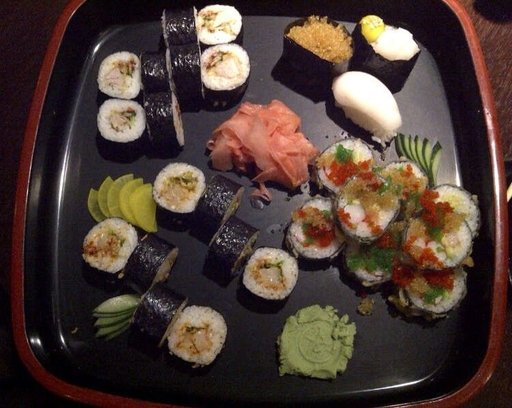

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Total image paths: {len(image_path_list)}')
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

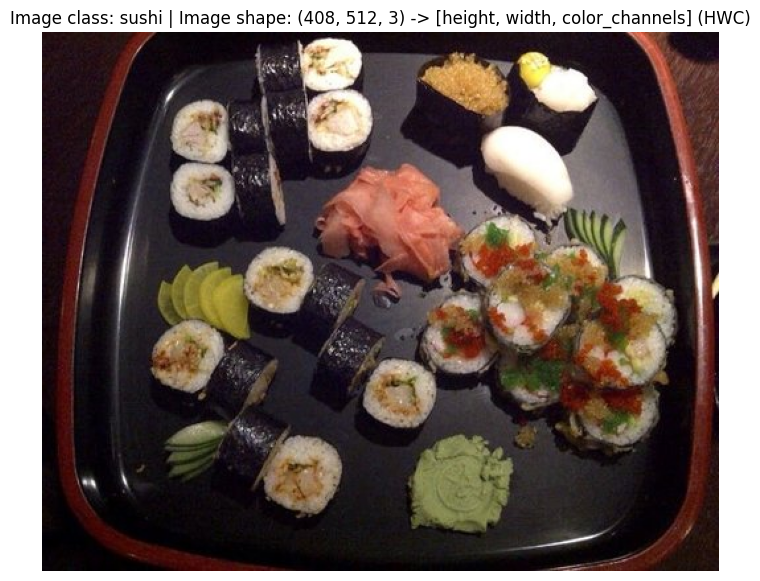

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Turns the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

# 04. Transforming Data

In order to use our image data with PyTorch, we need to perform a few steps:
1. Turn target data into tensors
2. Turn tensors into `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`
 

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 4.1 Transformaing data with `torchvision.transforms`

In [14]:
# Write a transform with image
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),            # Resize image
    transforms.RandomHorizontalFlip(p=0.5),     # Flit images horizontally
    transforms.ToTensor()                       # Turns image into torch.Tensor
])

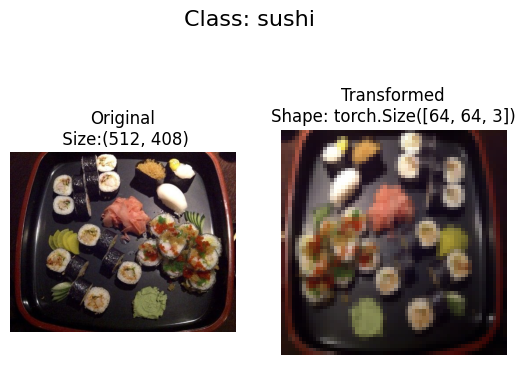

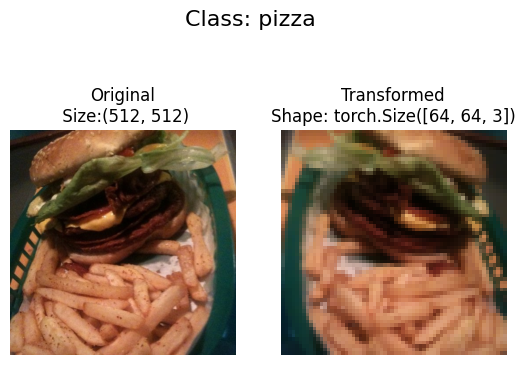

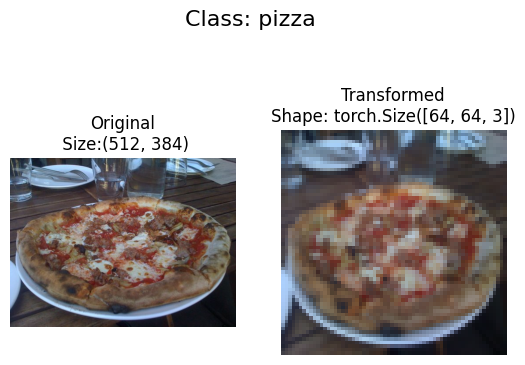

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Select random images from a path of images and loads/transforms them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original\n Size:{f.size}')
            ax[0].axis(False)

            transformed_image = transform(f).permute(1,2,0)         # (C,H,W) -> (H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, seed=42)

# 05. Loading image data using `ImageFolder`

In [16]:

# Use ImageFolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,     # transform for the data
                                  target_transform=None)        # transform for the labels

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,     # transform for the data
                                  target_transform=None)        # transform for the labels

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Get class dicts
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [20]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [21]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original Shape: torch.Size([3, 64, 64])
Image permute: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

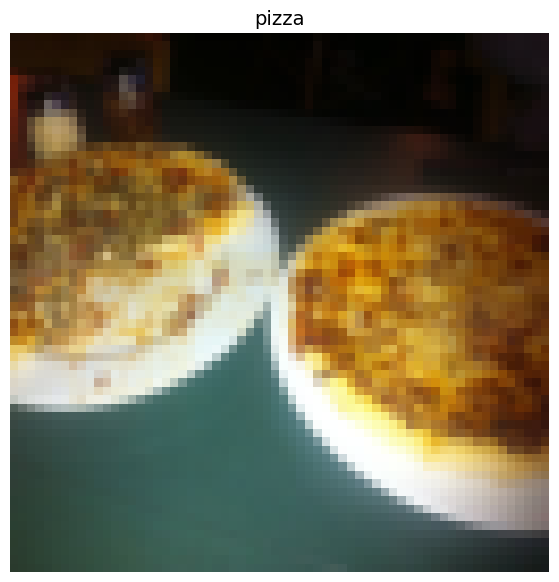

In [22]:
img_permute = img.permute(1,2,0)

print(f'Original Shape: {img.shape}')
print(f'Image permute: {img_permute.shape}')

# Plot image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 5.1 Turn loaded images into `DataLoaders`

In [23]:
# Turn train and test datasets into DataLoaders

from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count()
                              )

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=os.cpu_count()
                              )
train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x2991ad73380>,
 <torch.utils.data.dataloader.DataLoader at 0x2991d365310>)

In [24]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [25]:
img, label = next(iter(train_dataloader))

print(f'Image shape: {img.shape}')
print(f'Label shape {label.shape}')

Image shape: torch.Size([32, 3, 64, 64])
Label shape torch.Size([32])


# 06. Creating custom function to load custom dataset

In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [27]:
# Creating helper function to get class names

target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
    # 1. Get class names by scanning target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}...")
    # 3. Create a dictionary of index labels
    class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 6.1 Create a custom `Dataset` to replicate `ImageFolder`

In [30]:
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize custom dataset
    def __init__(self,
                 target_dir: str,
                 transform=None):
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(target_dir)

    # 4. Create a function to load images 
    def load_image(self, index: int) -> Image.Image:
        """ 
        Opens an image via a path and returns it
        """
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__() 
    def __len__(self) -> int:
        """
        Returns the total number of samples
        """
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Returns one sample of data, data and label (X, y).
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx


In [31]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()])

In [32]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                      transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x2991ad72e40>,
 <__main__.ImageFolderCustom at 0x2991d366710>)

In [33]:
train_data, train_data_custom

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 <__main__.ImageFolderCustom at 0x2991ad72e40>)

In [34]:
len(train_data), len(train_data_custom)

(225, 225)

In [35]:
len(test_data), len(test_data_custom)

(75, 75)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 6.2 Create a function to display random images

In [38]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting n equal to 10")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    # 5. Setup Plot
    plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, target_sample in enumerate(random_samples_idx):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]

        # 7. Adjust tensor dimensions for plotting
        target_image_adjust = target_image.permute(1, 2, 0)

        plt.subplot(1,n, i+1)
        plt.imshow(target_image_adjust)
        plt.axis('off')
        if classes:
            title = f'Class: {classes[target_label]}'
            if display_shape:
                title = title + f'=\nshape: {target_image.shape}'
        plt.title(title)



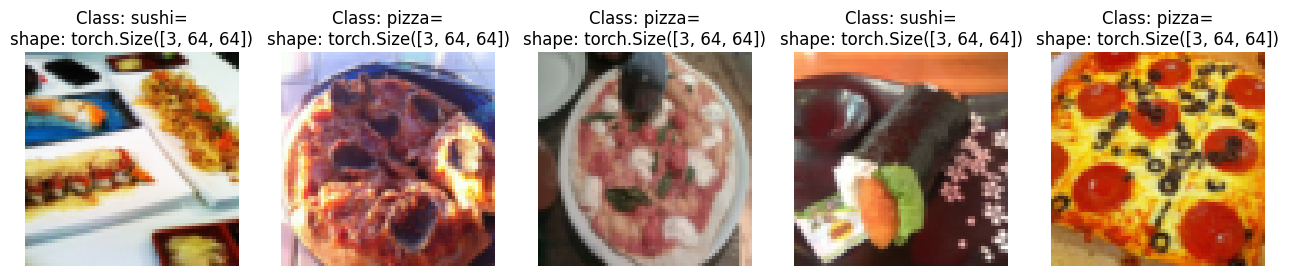

In [39]:
display_random_images(train_data,
                      classes=class_names,
                      n=5,
                      seed=42)

For display purposes, n shouldn't be larger than 10, setting n equal to 10


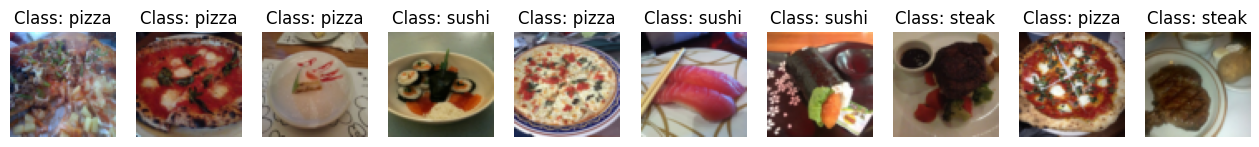

In [40]:
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 6.3 Turn custom loaded images into `DataLoaders`

In [41]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x2991d366990>,
 <torch.utils.data.dataloader.DataLoader at 0x2991ac77820>)

In [42]:
img_custom, label_custom = next(iter(train_dataloader_custom))

In [43]:
img_custom.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

# 07. Other forms of transforms

In [44]:
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224,224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                      transforms.Resize(size=(224,224)),
                                      transforms.ToTensor(),
])

In [45]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [46]:
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

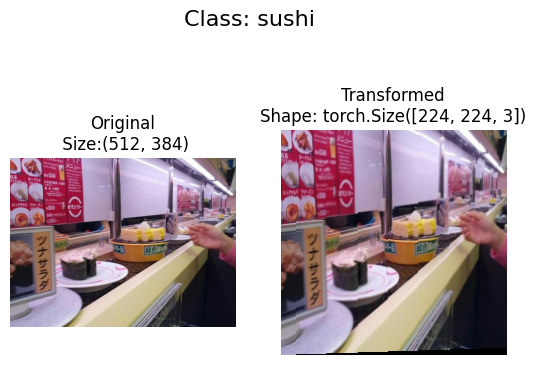

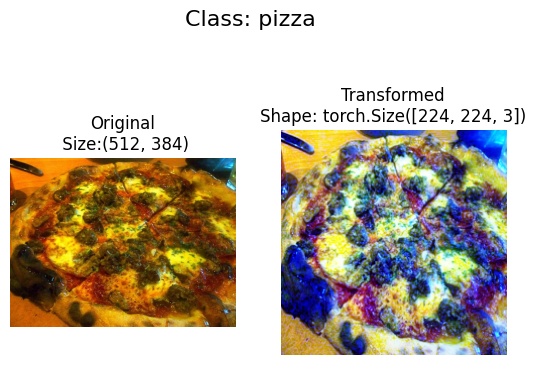

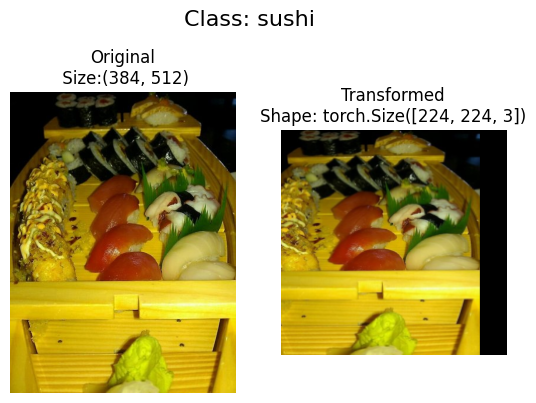

In [49]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

# 08. Model 0: Tiny Vgg without data augmentation

### 8.1 Creating transforms and loading data for model 0

In [51]:
simple_transform = transforms.Compose([
                                        transforms.Resize(size=(64,64)),
                                        transforms.ToTensor()
])

In [53]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

# 2. Turn datasets into dataloaders
import os 
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [54]:
# Create dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

### 8.2 Create TinyVGG model class

In [97]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
            )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
            )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*13*13,
                out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)        
        return x

In [98]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,    # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)
                  ).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 8.3 Try forward pass on a single image (To test model)

In [87]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [99]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9127e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0238e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3785e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2131e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 8.4 Getting model summary using `Torchinfo`

In [100]:
from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

# 09. Training and testing loop functions

In [125]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X,y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step 
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==1).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss/len(dataloader)
        train_acc = train_acc/len(dataloader)
        
    return train_loss, train_acc



In [132]:
# Create test step function

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy metric
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    
    return test_loss, test_acc

In [133]:
# Create a train() function to combine train_step() and test_step()

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
    
    # Create empty model results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': [],
               }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model_0,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model_0,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
    
        print(f'Epoch: {epoch}  | Train loss: {train_loss:.4f}  | Train acc: {train_acc:.4f}    | Test loss: {test_loss:.4f}  | Test acc: {test_acc:.4f}')

        # Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

#### 9.1 Train and evaluate model 0

In [138]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of Epochs 
NUM_EPOCHS = 50

# Recreate instance of model
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start timer 
import time

start_time = time.time()

# Train Model_0

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer 
end_time = time.time()
print(f'Total training time: {end_time - start_time:.2f} seconds.')

  2%|▏         | 1/50 [00:56<46:10, 56.54s/it]

Epoch: 0  | Train loss: 0.1614  | Train acc: 0.0024    | Test loss: 1.0983  | Test acc: 0.3011


  4%|▍         | 2/50 [01:15<27:29, 34.36s/it]

Epoch: 1  | Train loss: 0.1621  | Train acc: 0.0000    | Test loss: 1.0697  | Test acc: 0.5417


  6%|▌         | 3/50 [01:33<21:16, 27.15s/it]

Epoch: 2  | Train loss: 0.1514  | Train acc: 0.0106    | Test loss: 1.0807  | Test acc: 0.4924


  8%|▊         | 4/50 [01:55<19:01, 24.82s/it]

Epoch: 3  | Train loss: 0.1575  | Train acc: 0.0035    | Test loss: 1.0609  | Test acc: 0.5833


 10%|█         | 5/50 [02:16<17:36, 23.47s/it]

Epoch: 4  | Train loss: 0.1528  | Train acc: 0.1350    | Test loss: 1.0655  | Test acc: 0.5644


 12%|█▏        | 6/50 [02:37<16:46, 22.87s/it]

Epoch: 5  | Train loss: 0.1478  | Train acc: 0.0044    | Test loss: 1.0148  | Test acc: 0.5426


 14%|█▍        | 7/50 [02:58<15:53, 22.18s/it]

Epoch: 6  | Train loss: 0.1519  | Train acc: 0.1307    | Test loss: 0.9351  | Test acc: 0.6042


 16%|█▌        | 8/50 [03:19<15:09, 21.65s/it]

Epoch: 7  | Train loss: 0.1405  | Train acc: 0.1313    | Test loss: 1.0034  | Test acc: 0.4432


 18%|█▊        | 9/50 [03:39<14:24, 21.10s/it]

Epoch: 8  | Train loss: 0.0874  | Train acc: 0.0101    | Test loss: 1.0723  | Test acc: 0.3324


 20%|██        | 10/50 [03:58<13:48, 20.71s/it]

Epoch: 9  | Train loss: 0.1965  | Train acc: 0.0029    | Test loss: 1.0566  | Test acc: 0.4044


 22%|██▏       | 11/50 [04:16<12:49, 19.72s/it]

Epoch: 10  | Train loss: 0.1350  | Train acc: 0.1317    | Test loss: 0.9706  | Test acc: 0.5530


 24%|██▍       | 12/50 [04:34<12:04, 19.07s/it]

Epoch: 11  | Train loss: 0.1612  | Train acc: 0.0073    | Test loss: 0.9320  | Test acc: 0.5445


 26%|██▌       | 13/50 [04:51<11:28, 18.61s/it]

Epoch: 12  | Train loss: 0.0378  | Train acc: 0.1274    | Test loss: 0.9974  | Test acc: 0.4129


 28%|██▊       | 14/50 [05:09<10:56, 18.25s/it]

Epoch: 13  | Train loss: 0.1889  | Train acc: 0.0058    | Test loss: 1.0587  | Test acc: 0.4744


 30%|███       | 15/50 [05:26<10:31, 18.04s/it]

Epoch: 14  | Train loss: 0.0833  | Train acc: 0.0065    | Test loss: 0.9910  | Test acc: 0.5142


 32%|███▏      | 16/50 [05:43<10:06, 17.85s/it]

Epoch: 15  | Train loss: 0.0590  | Train acc: 0.1282    | Test loss: 0.9895  | Test acc: 0.5038


 34%|███▍      | 17/50 [06:01<09:46, 17.78s/it]

Epoch: 16  | Train loss: 0.0775  | Train acc: 0.0076    | Test loss: 1.0207  | Test acc: 0.4839


 36%|███▌      | 18/50 [06:18<09:24, 17.65s/it]

Epoch: 17  | Train loss: 0.0653  | Train acc: 0.0044    | Test loss: 1.0623  | Test acc: 0.4025


 38%|███▊      | 19/50 [06:36<09:06, 17.62s/it]

Epoch: 18  | Train loss: 0.0989  | Train acc: 0.0082    | Test loss: 1.0389  | Test acc: 0.5350


 40%|████      | 20/50 [06:54<08:51, 17.71s/it]

Epoch: 19  | Train loss: 0.0790  | Train acc: 0.0043    | Test loss: 1.0441  | Test acc: 0.4441


 42%|████▏     | 21/50 [07:11<08:31, 17.64s/it]

Epoch: 20  | Train loss: 0.1295  | Train acc: 0.0092    | Test loss: 1.0867  | Test acc: 0.4943


 44%|████▍     | 22/50 [07:29<08:12, 17.59s/it]

Epoch: 21  | Train loss: 0.1165  | Train acc: 0.0065    | Test loss: 1.0091  | Test acc: 0.5559


 46%|████▌     | 23/50 [07:46<07:53, 17.55s/it]

Epoch: 22  | Train loss: 0.0531  | Train acc: 0.0060    | Test loss: 1.0974  | Test acc: 0.3826


 48%|████▊     | 24/50 [08:04<07:36, 17.54s/it]

Epoch: 23  | Train loss: 0.2375  | Train acc: 0.0092    | Test loss: 1.1032  | Test acc: 0.4744


 50%|█████     | 25/50 [08:21<07:18, 17.54s/it]

Epoch: 24  | Train loss: 0.0262  | Train acc: 0.1286    | Test loss: 0.9869  | Test acc: 0.5455


 52%|█████▏    | 26/50 [08:39<07:04, 17.71s/it]

Epoch: 25  | Train loss: 0.0827  | Train acc: 0.0074    | Test loss: 0.9971  | Test acc: 0.5152


 54%|█████▍    | 27/50 [08:57<06:47, 17.72s/it]

Epoch: 26  | Train loss: 0.0273  | Train acc: 0.1321    | Test loss: 1.0833  | Test acc: 0.4034


 56%|█████▌    | 28/50 [09:14<06:21, 17.34s/it]

Epoch: 27  | Train loss: 0.0682  | Train acc: 0.0082    | Test loss: 1.0953  | Test acc: 0.4337


 58%|█████▊    | 29/50 [1:18:49<7:22:41, 1264.83s/it]

Epoch: 28  | Train loss: 0.0202  | Train acc: 0.1316    | Test loss: 1.0938  | Test acc: 0.4953


 60%|██████    | 30/50 [1:19:08<4:57:03, 891.16s/it] 

Epoch: 29  | Train loss: 0.1949  | Train acc: 0.0045    | Test loss: 1.1018  | Test acc: 0.4650


 62%|██████▏   | 31/50 [1:19:30<3:19:33, 630.21s/it]

Epoch: 30  | Train loss: 0.0875  | Train acc: 0.0029    | Test loss: 1.0414  | Test acc: 0.4744


 64%|██████▍   | 32/50 [1:19:49<2:14:02, 446.83s/it]

Epoch: 31  | Train loss: 0.0227  | Train acc: 0.1302    | Test loss: 1.1473  | Test acc: 0.4545


 66%|██████▌   | 33/50 [1:20:08<1:30:17, 318.67s/it]

Epoch: 32  | Train loss: 0.0268  | Train acc: 0.1325    | Test loss: 1.1996  | Test acc: 0.3731


 68%|██████▊   | 34/50 [1:20:29<1:01:10, 229.38s/it]

Epoch: 33  | Train loss: 0.0504  | Train acc: 0.0055    | Test loss: 1.1977  | Test acc: 0.4545


 70%|███████   | 35/50 [1:20:52<41:47, 167.19s/it]  

Epoch: 34  | Train loss: 0.0396  | Train acc: 0.0057    | Test loss: 1.2078  | Test acc: 0.4441


 72%|███████▏  | 36/50 [1:21:13<28:47, 123.41s/it]

Epoch: 35  | Train loss: 0.0354  | Train acc: 0.1300    | Test loss: 1.3266  | Test acc: 0.4848


 74%|███████▍  | 37/50 [1:21:32<19:59, 92.30s/it] 

Epoch: 36  | Train loss: 0.0543  | Train acc: 0.0043    | Test loss: 1.3322  | Test acc: 0.3826


 76%|███████▌  | 38/50 [1:21:52<14:04, 70.40s/it]

Epoch: 37  | Train loss: 0.0908  | Train acc: 0.1281    | Test loss: 1.3089  | Test acc: 0.4347


 78%|███████▊  | 39/50 [1:22:11<10:06, 55.16s/it]

Epoch: 38  | Train loss: 0.1190  | Train acc: 0.0056    | Test loss: 1.2354  | Test acc: 0.4347


 80%|████████  | 40/50 [1:22:31<07:26, 44.63s/it]

Epoch: 39  | Train loss: 0.0447  | Train acc: 0.0060    | Test loss: 1.2447  | Test acc: 0.4252


 82%|████████▏ | 41/50 [1:22:50<05:32, 36.91s/it]

Epoch: 40  | Train loss: 0.2322  | Train acc: 0.0077    | Test loss: 1.2376  | Test acc: 0.4451


 84%|████████▍ | 42/50 [1:23:10<04:14, 31.83s/it]

Epoch: 41  | Train loss: 0.1858  | Train acc: 0.0046    | Test loss: 1.1445  | Test acc: 0.5237


 86%|████████▌ | 43/50 [1:23:31<03:18, 28.38s/it]

Epoch: 42  | Train loss: 0.1010  | Train acc: 0.0095    | Test loss: 1.1696  | Test acc: 0.4451


 88%|████████▊ | 44/50 [1:23:50<02:34, 25.68s/it]

Epoch: 43  | Train loss: 0.1835  | Train acc: 0.1307    | Test loss: 1.3056  | Test acc: 0.4545


 90%|█████████ | 45/50 [1:24:09<01:58, 23.67s/it]

Epoch: 44  | Train loss: 0.1789  | Train acc: 0.0036    | Test loss: 1.3973  | Test acc: 0.4934


 92%|█████████▏| 46/50 [1:24:28<01:29, 22.40s/it]

Epoch: 45  | Train loss: 0.2090  | Train acc: 0.1326    | Test loss: 1.2460  | Test acc: 0.5133


 94%|█████████▍| 47/50 [1:24:50<01:06, 22.14s/it]

Epoch: 46  | Train loss: 0.0642  | Train acc: 0.0032    | Test loss: 1.2672  | Test acc: 0.4242


 96%|█████████▌| 48/50 [1:25:13<00:44, 22.36s/it]

Epoch: 47  | Train loss: 0.2690  | Train acc: 0.0072    | Test loss: 1.3636  | Test acc: 0.4754


 98%|█████████▊| 49/50 [1:25:34<00:21, 21.88s/it]

Epoch: 48  | Train loss: 0.0684  | Train acc: 0.1310    | Test loss: 1.2529  | Test acc: 0.5047


100%|██████████| 50/50 [1:25:53<00:00, 103.06s/it]

Epoch: 49  | Train loss: 0.0951  | Train acc: 0.0071    | Test loss: 1.3701  | Test acc: 0.4943
Total training time: 5153.24 seconds.


### 9.2 Plot the loss curves of model 0

In [141]:
# Get the model_0 result keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

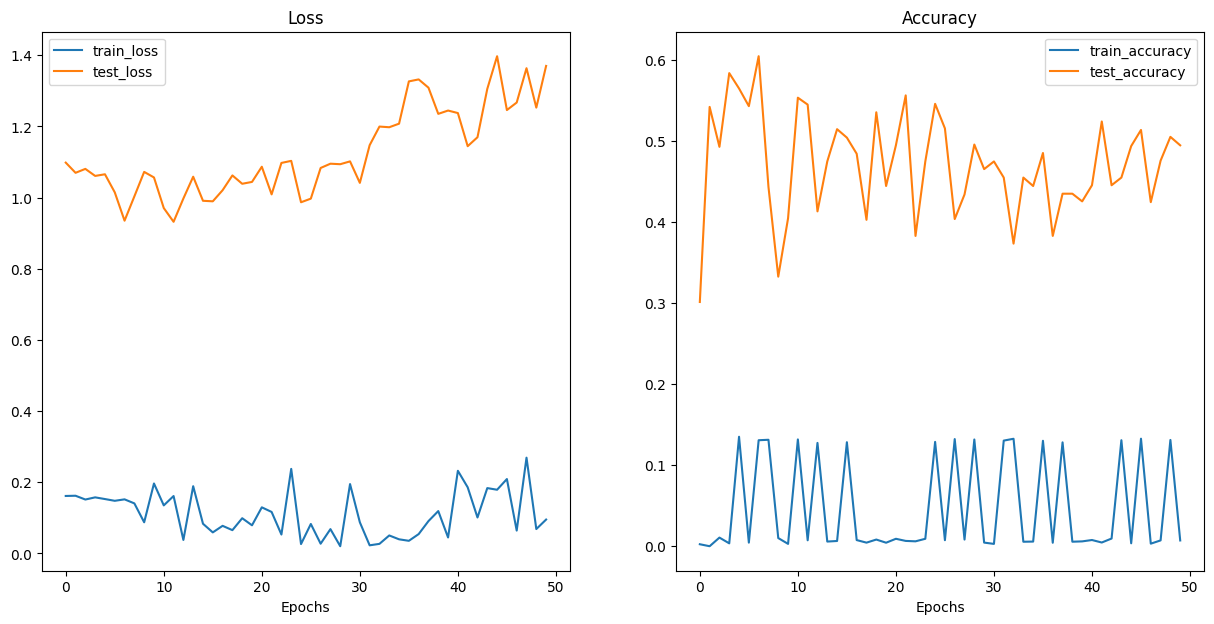

In [142]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get accuracy values of results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs were there
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_0_results)


# 10. Model 1: TinyVGG with Data Augmentation

### 10.1 Create transform with data augmentation

In [144]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
                                              transforms.Resize(size=(64,64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()
]
)

test_transform_trivial = transforms.Compose([
                                              transforms.Resize(size=(64,64)),
                                              transforms.ToTensor()
]
)

### 10.2 Create train and test `Dataset's` and `DataLoader's` with data augmentation

In [146]:
# Turn image folders into Datasets

from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_augmented = datasets.ImageFolder(root=test_dir,
                                            transform=test_transform_trivial)


In [147]:
# Turn Datasets into DataLoaders

import os

BATCH_SIZE = 35
NUM_WORKERS = os.cpu_count()


torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)


### 10.3 Construct and train model 1

This type we will use same model architecture except this time we will use augmented data

In [150]:
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=3)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [151]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss funciton
loss_fn = nn.CrossEntropyLoss()

# Setup optimizer
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.001)

# Start timer
start_time = time.time()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = time.time()

print(f'Total Training time for model_1: {end_time-start_time:.2f} seconds')

 20%|██        | 1/5 [00:22<01:28, 22.05s/it]

Epoch: 0  | Train loss: 0.2250  | Train acc: 0.0784    | Test loss: 1.5401  | Test acc: 0.5143


 40%|████      | 2/5 [00:42<01:03, 21.22s/it]

Epoch: 1  | Train loss: 0.1981  | Train acc: 0.0786    | Test loss: 1.5401  | Test acc: 0.5143


 60%|██████    | 3/5 [01:03<00:42, 21.04s/it]

Epoch: 2  | Train loss: 0.1214  | Train acc: 0.0669    | Test loss: 1.5401  | Test acc: 0.5143


 80%|████████  | 4/5 [01:24<00:20, 20.92s/it]

Epoch: 3  | Train loss: 0.2017  | Train acc: 0.0779    | Test loss: 1.5401  | Test acc: 0.5143


100%|██████████| 5/5 [01:44<00:00, 20.96s/it]

Epoch: 4  | Train loss: 0.1330  | Train acc: 0.0978    | Test loss: 1.5401  | Test acc: 0.5143
Total Training time for model_1: 104.82 seconds


In [152]:
model_1_results

{'train_loss': [0.22501626415018985,
  0.19805193359126808,
  0.12144894984103062,
  0.2016895477317496,
  0.1329997572769885],
 'train_acc': [0.07844251114074305,
  0.07856418056176903,
  0.06685136225864519,
  0.07787086955242109,
  0.09776195223391058],
 'test_loss': [1.5401499271392822,
  1.5401499271392822,
  1.5401499271392822,
  1.5401499271392822,
  1.5401499271392822],
 'test_acc': [0.5142857142857142,
  0.5142857142857142,
  0.5142857142857142,
  0.5142857142857142,
  0.5142857142857142]}

### 10.4 Plot loss curves for model 1

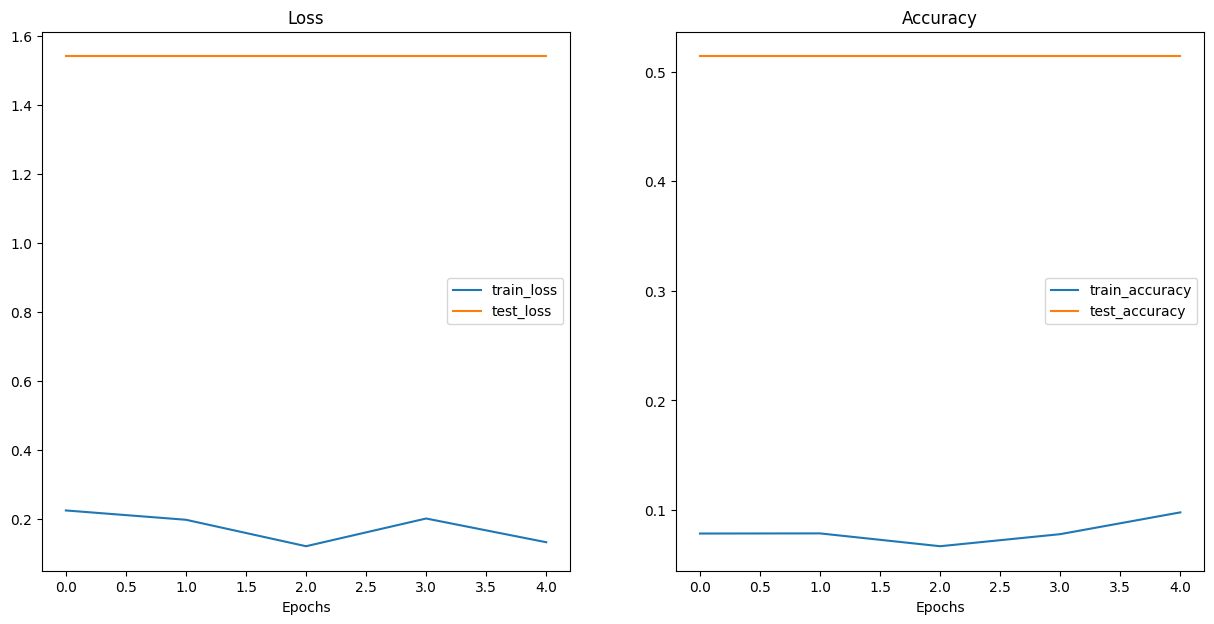

In [153]:
plot_loss_curves(model_1_results)